##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Visualization with Alpha Transparency

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce feature visualizations that use alpha transparency to reduce visual noise, like the ones found in [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/). 

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [ ]:
# Install Lucid
!pip install --quiet "lucid>=0.3.11"
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

In [3]:
# Import libraries
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.io import show, load
from lucid.misc.io.reading import read

In [4]:
# Import the InceptionV1 (GoogLeNet) model from the Lucid modelzoo
model = models.InceptionV1()
model.load_graphdef()

## Setup

In [5]:
def global_step():
    return tf.cast(tf.compat.v1.train.get_or_create_global_step(), tf.float32)

@objectives.wrap_objective(require_format='NHWC')
def penalize_alpha():
    def inner(T):
        return tf.reduce_mean(T('input')[..., 3:4])
    return inner

@objectives.wrap_objective(require_format='NHWC')
def decay(n_steps):
    def inner(T):
        return 1 - (global_step() / n_steps)
    return inner

@objectives.wrap_objective(require_format='NHWC')
def only_after(n_steps):
    def inner(T):
        return tf.cond(global_step() < n_steps, lambda: 0.0, lambda: 1.0)
    return inner

In [6]:
def alpha_feature_vis(neurons, layer='mixed4d', size=50, margin=30, k=0.7,
                      verbose=True, n_steps=1000):
    n_batch = len(neurons)
    size += 2*margin

    obj = 0.5 * sum([
        objectives.neuron(layer + '_pre_relu', neurons[i], batch=i) +
        objectives.channel(layer, neurons[i], batch=i)
        for i in range(n_batch)
    ]) + sum([
        -1 * decay(n_steps*1.5) * objectives.blur_input_each_step(),
        -1 * decay(n_steps) * objectives.blur_alpha_each_step(),
        -20000 * only_after(150) * decay(n_steps*1.5) * penalize_alpha()
    ])

    param_f = lambda: param.image(size, fft=True, decorrelate=True, batch=n_batch, alpha=True)

    transforms = [
        transform.collapse_alpha_random(),
        transform.pad(4, mode='constant', constant_value=1),
        transform.jitter(4),
        transform.jitter(4),
        transform.jitter(8),
        transform.jitter(8),
        transform.jitter(8),
        transform.random_scale([0.995**n for n in range(-5,80)] + [0.998**n for n in 2*list(range(20,40))]),
        transform.random_rotate(list(range(-20,20))+list(range(-10,10))+list(range(-5,5))+5*[0])
    ]

    img_steps = render.render_vis(model, obj, param_f, transforms=transforms,
                                  thresholds=(n_steps//4, n_steps//2, n_steps),
                                  verbose=verbose)

    imgs = img_steps[-1]  # remove thresholds
    img = np.hstack(imgs) # remove batch
    img_rgb = img[:,:,:3]
    img_a = img[:,:,3:]

    img = img_rgb*((1-k)+k*img_a) + k*(1-img_a)
    show(img)
    return img

## Run

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13b8576d0>
250 6666.7026



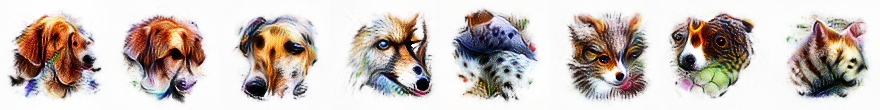

500 5927.9233



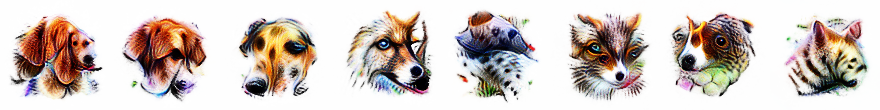

1000 11673.266



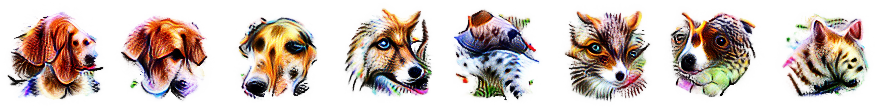


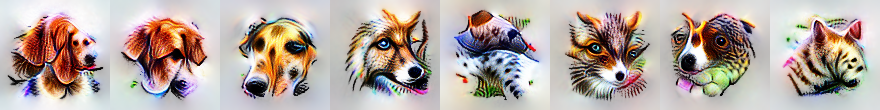

In [7]:
# Dog and cat neurons
_ = alpha_feature_vis([426, 436, 43, 477, 383, 493, 517, 221])

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13b8270a0>
250 -3473.7383



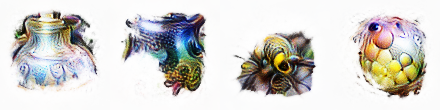

500 524.38403



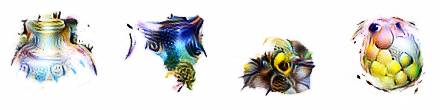

1000 1861.2456



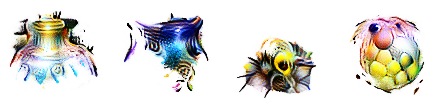


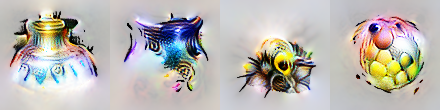

In [8]:
# Vase, flower, and lemon neurons
_ = alpha_feature_vis([469, 234, 25, 185])

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x13c6b6460>
250 -1435.8584



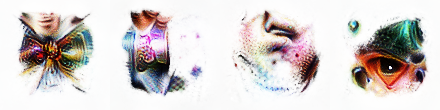

500 179.06982



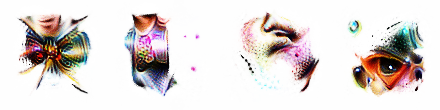

1000 3257.308



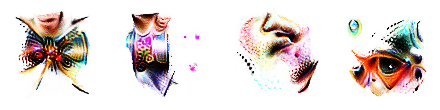


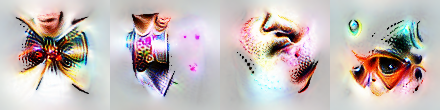

In [9]:
# Bow tie, lapel, and sunglasses neurons
_ = alpha_feature_vis([490, 519, 458, 442])